In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

from mnist_experiment_utils import load_data, get_model_noFeedbackImprovement
from experiment_utils import plot_history, history_todict

from keras.optimizers import SGD

/home/sicarbonnell/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
result_file = 'results_noFeedbackImprovement.p'

In [ ]:
results = dict()

for experiment in range(10):
    results.update({experiment:{}})
    x_train, y_train, x_test, y_test = load_data(experiment)

    lr = 10
    batch_size = 128 # -> full batch training since there are 100 training samples
    epochs = 4000
    verbose = 0

    for i in range(0,10):
        model = get_model_noFeedbackImprovement(experiment)
        
        # collect relu's regime at initialization in each neuron for training and test images
        #no fake firings needed for last layer when extracting firings since only relu's input is extracted
        firing_train = [np.zeros_like(x_train,dtype = 'float32')]*(9)
        firing_test = [np.zeros_like(x_test,dtype = 'float32')]*(9)
        firing_train = model.get_firing([x_train]+firing_train, batch_size = 32)
        firing_test = model.get_firing([x_test]+firing_test, batch_size = 32)

        for l in model.layers:
            if l.name != 'dense'+str(i):
                l.trainable = False
                
        # ReLU's of the trained layer should be the only ones able to change of regime
        model.set_firing_mode(firing_fixed=True)
        K.set_value(model.relu_layers[i].firing_fixed,False)
                
        model.compile(loss='categorical_crossentropy',
                      optimizer=SGD(lr),
                      metrics=['accuracy'])

        history = model.fit([x_train]+firing_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=verbose)

        score_train = model.evaluate([x_train]+firing_train, y_train, verbose=0)
        score_test = model.evaluate([x_test]+firing_test, y_test, verbose=0)

        results[experiment].update({i:[score_train,score_test,history_todict(history)]})

    with open(result_file,'wb') as f:
        pickle.dump(results,f)
        
    print('Experiment '+str(experiment)+' done.')

Experiment 1 done.
Experiment 2 done.


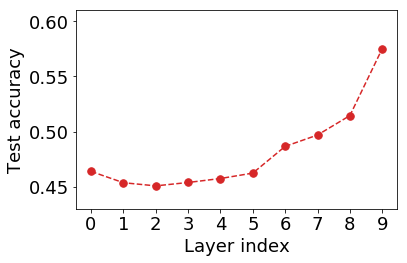

In [4]:
%matplotlib inline

with open(result_file,'rb') as f:
    results = pickle.load(f)
    
nb_experiments = len(results.keys())

test_accs = np.zeros(10)
for experiment in range(nb_experiments):
    test_accs += np.array([results[experiment][i][1][1] for i in range(0,10)])/nb_experiments

train_accs = np.zeros(10)
for experiment in range(nb_experiments):
    train_accs += np.array([results[experiment][i][0][1] for i in range(0,10)])/nb_experiments

matplotlib.rcParams.update({'font.size': 18})

plt.plot(np.arange(10),test_accs,'C3--')
# plt.plot(np.arange(10),train_accs,'C0--')
plt.plot(np.arange(10),test_accs,'C3.',ms = 15)
plt.xlabel('Layer index')
plt.ylabel('Test accuracy')
plt.xticks(range(10))
plt.ylim(0.43,0.61)

plt.tight_layout()
plt.plot()

plt.savefig('figures/MNIST_noFeedbackImprovement.eps',format='eps', dpi=200)
# plt.savefig('figures/MNIST_noFeedbackImprovement.png',format='png', dpi=300)